#jenken data load

Note that below code is done on Colaboratory.

In [1]:
!pip install keras==2.2.4
!pip install scikit-learn==0.19.0

     |████████████████████████████████| 317kB 8.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 12.4MB 6.9MB/s 
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.0 which is incompatible.
ERROR: librosa 0.6.3 has requirement scikit-learn!=0.19.0,>=0.14.0, but you'll have scikit-learn 0.19.0 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.0 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement scikit-learn>=0.19.1, but you'll have scikit-learn 0.19.0 which is incompatible.
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [2]:
!git clone https://github.com/karaage0703/janken_dataset

Cloning into 'janken_dataset'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from PIL import Image
import glob, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras
from sklearn.model_selection import train_test_split

def load_images(path):
    result_img = []
    file_name = glob.glob(path + "*")
    for name in file_name:
        img = Image.open(name)
        img = image.img_to_array(img)
        img = cv2.resize(img,(96, 96))
        result_img.append(img)
    return np.array(result_img)

Using TensorFlow backend.


In [4]:
gu = load_images("janken_dataset/gu/")
pa = load_images("janken_dataset/pa/")
gu_label = np.ones(len(gu))
pa_label = np.zeros(len(pa))

gu /= 255
pa /= 255

gu_train, gu_test, y_gu_train, y_gu_test = train_test_split(gu, gu_label, train_size=0.8)
pa_train, pa_test, y_pa_train, y_pa_test = train_test_split(pa, pa_label, train_size=0.8)

X_train = np.vstack((gu_train, pa_train))
X_test = np.vstack((gu_test, pa_test))
y_train = np.hstack((y_gu_train, y_pa_train))
y_test = np.hstack((y_gu_test, y_pa_test))

Y_train = keras.utils.to_categorical(y_train)
Y_test = keras.utils.to_categorical(y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(80, 96, 96, 3)
(80, 2)
(21, 96, 96, 3)
(21, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


###(Fig show)

In [0]:
def plot_fig(fig1, fig2, fig3, fig4):
    plt.figure(figsize=(15,60))
    plt.subplot(1,4,1)
    plt.imshow(fig1)
    plt.axis("off")
    plt.title("train[0]")

    plt.subplot(1,4,2)
    plt.imshow(fig2)
    plt.axis("off")
    plt.title("train[1]")

    plt.subplot(1,4,3)
    plt.imshow(fig3)
    plt.axis("off")
    plt.title("test[0]")

    plt.subplot(1,4,4)
    plt.imshow(fig4)
    plt.axis("off")
    plt.title("test[1]")
    plt.show()

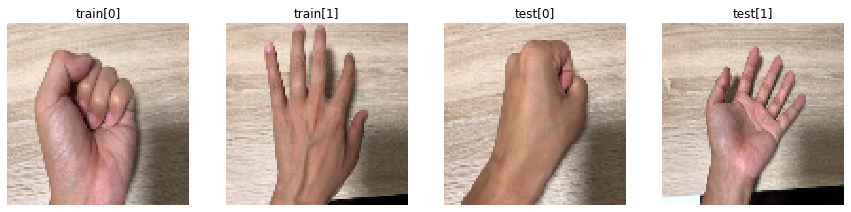

In [6]:
plot_fig(gu_train[0], pa_train[0], gu_test[0], pa_test[0])

#CNN

##MobileNet V2 with ArcFace(2 classes)
(Of course 3 classes is possible.)

In [0]:
from keras.applications import MobileNetV2
from keras.engine.topology import Layer
from keras import backend as K
from keras.layers import Input, Activation
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
from sklearn import metrics

def train_mobileV2(X_train, Y_train, X_test, Y_test, epoch, classes=2, alpha_=0.5):
    mobile = MobileNetV2(include_top=True, input_shape=X_train.shape[1:], alpha=alpha_,
                         weights='imagenet')
    
    # 最終層削除
    mobile.layers.pop()
    v2 = Model(inputs=mobile.input,outputs=mobile.layers[-1].output)

    model = build_arcface(X_train, classes, v2)

    datagen = ImageDataGenerator(rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True)
    
    datagen.fit(X_train)

    #cnnの学習
    hist = model.fit_generator(datagen.flow([X_train, Y_train], Y_train, batch_size=32),
                               steps_per_epoch=X_train.shape[0] /32,
                               validation_data=([X_test, Y_test], Y_test),
                               epochs=epoch, 
                               verbose=1)

    plt.figure()               
    plt.plot(hist.history['val_acc'],label="val_acc")
    plt.legend(loc="lower right")
    plt.show()

    return model

# mobilenetV2と接合して学習
def build_arcface(x, classes, base_model):
    #add new layers 
    hidden = base_model.output
    yinput = Input(shape=(classes,)) #ArcFaceで使用
    # stock hidden model
    c = Arcfacelayer(classes, 30, 0.05)([hidden,yinput]) #outputをクラス数と同じ数に
    prediction = Activation('softmax')(c)
    model = Model(inputs=[base_model.input, yinput], outputs=prediction)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, amsgrad=True),
                  metrics=['accuracy'])

    return model

#arcfaceの層
class Arcfacelayer(Layer):
    # s:softmaxの温度パラメータ, m:margin
    def __init__(self, output_dim, s=30, m=0.50, easy_margin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        super(Arcfacelayer, self).__init__()

    # 重みの作成
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Arcfacelayer, self).build(input_shape)

    # mainの処理 
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0]) # x = x'/ ||x'||2
        k_normalize = tf.math.l2_normalize(self.kernel) # Wj = Wj' / ||Wj'||2

        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m

        cosine = K.dot(x_normalize, k_normalize) # W.Txの内積
        sine = K.sqrt(1.0 - K.square(cosine))

        phi = cosine * cos_m - sine * sin_m #cos(θ+m)の加法定理

        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine) 

        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 

        # 正解クラス:cos(θ+m) 他のクラス:cosθ 
        output = (y * phi) + ((1.0 - y) * cosine) 
        output *= self.s

        return output

    def compute_output_shape(self, input_shape):

        return (input_shape[0][0], self.output_dim) #入力[x,y]のためx[0]はinput_shape[0][0]

##Grad-CAM

In [0]:
import time

def GradCam(model, x, layer_name, class_, top50):
    X = np.expand_dims(x,axis=0)
    
    # 前処理
    target = np.array([0, 1]).reshape((1,-1))
    class_idx = class_
    class_output = model.output[:, class_idx]
    
    # 勾配を取得
    before = time.time()
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.input[0],model.input[1]], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数
    
    output, grads_val = gradient_function([X, target])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    if top50 == True:
        label = np.argsort(weights)
        cam = np.dot(output[:,:,label[-50:]], weights[label[-50:]])
    else:
        cam = np.dot(output, weights)

    # ヒートマップにして合成
    cam = cv2.resize(cam, (x.shape[1], x.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x*255 / 2)   # もとの画像に合成

    return jetcam, weights, time.time()-before

##Faster-Grad-CAM

In [0]:
from sklearn.cluster import KMeans

# compare grad and faster-grad
def show_result(model, model_small, layer_name, data, no, kmeans, channel_weight, channel_adress, top50=False):
    original, result_grad, result_faster, time0, time1 = [], [], [], [], []
    for i in range(5):
        original.append(data[no[i]]) 
        img0, _, time_0 = GradCam(model, data[no[i]], layer_name, 1, top50)
        img1, time_1 = predict_faster_gradcam(data[no[i]], model_small, kmeans, channel_weight, channel_adress)
        result_grad.append(img0)
        result_faster.append(img1)
        time0.append(time_0)
        time1.append(time_1)

    plt.figure(figsize=(15,10))
    for i in range(5):
        plt.subplot(3,5,i+1)
        plt.axis("off")
        if i == 0:
            plt.title("original")
        plt.imshow(original[i])
    for i in range(5):
        plt.subplot(3,5,i+6)
        plt.axis("off")
        if i == 0:
            time_ = int(np.mean(time1)*1000)
            plt.title("Faster-Grad-CAM \n(%d msec)" % time_)
        plt.imshow(array_to_img(result_faster[i]))
    for i in range(5):
        plt.subplot(3,5,i+11)
        plt.axis("off")
        if i == 0:
            time_ = int(np.mean(time0)*1000)
            plt.title("Grad-CAM \n(%d msec)" % time_)
        plt.imshow(array_to_img(result_grad[i]))
    plt.show()

def train_faster_gradcam(x_normal, x_anomaly, model, clusters=10):
    # Arcfaceを削除
    model_embed = Model(model.get_layer(index=0).input, [model.layers[-13].get_output_at(-1), model.layers[-4].get_output_at(-1)])

    # pa class data
    _, vector_normal = model_embed.predict(x_normal)

    # gu class data
    _, vector_anomaly = model_embed.predict(x_anomaly)# shape[(len(x), 3, 3, 480), (len(x), 1280)]

    # k-means
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(vector_anomaly)
    labels = kmeans.labels_

    # channel database
    channel_weight, channel_adress = [], []
    temp_weight = np.zeros((clusters, 480))# 480="block_16_expand_relu".output
    print("Making Database...")
    for i in range(len(labels)):
        # x_anomalyについて一個ずつ重みを加算していく
        _, weight, _ = GradCam(model, x_anomaly[i], "block_16_expand_relu", 1, False)
        temp_weight[labels[i]] += weight #要確認
        print(i+1,"/",len(labels))

    for i in range(clusters):
        number = np.where(labels == i, 1, 0) #クラスタ内の個数
        average_weight = temp_weight[i] / np.sum(number) #重みの平均
        weight_adress = np.argsort(average_weight)
        channel_adress.append(weight_adress[-50:])
        channel_weight.append(average_weight[weight_adress[-50:]])

    return model_embed, kmeans, np.array(channel_weight), np.array(channel_adress), vector_normal

def predict_faster_gradcam(x, model, kmeans, channel_weight, channel_adress):
    before = time.time()
    channel_out, vector = model.predict(np.expand_dims(x, axis=0))
    channel_out = channel_out[0]
    cluster_no = kmeans.predict(vector)
    # レイヤーのアウトプットに乗じる
    cam = np.dot(channel_out[:,:,channel_adress[cluster_no][0]], channel_weight[cluster_no][0])

    # ヒートマップにして合成
    cam = cv2.resize(cam, (x.shape[1], x.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x*255 / 2)   # もとの画像に合成

    return jetcam, time.time()-before

#Train

##ArcFace












8339456/8331712 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/20
3/2 [====================================] - 17s 6s/step - loss: 1.6684 - acc: 0.0000e+00 - val_loss: 1.6174 - val_acc: 0.0000e+00
Epoch 2/20
3/2 [====================================] - 0s 90ms/step - loss: 1.5990 - acc: 0.0000e+00 - val_loss: 1.4603 - val_acc: 0.0000e+00
Epoch 3/20
3/2 [====================================] - 0s 85ms/step - loss: 1.4789 - acc: 0.0000e+00 - val_loss: 1.3241 - val_acc: 0.0000e+00
Epoch 4/20
3/2 [====================================] - 0s 89ms/step - loss: 1.3799 - acc: 0.0000e+00 - val_loss: 1.1869 - val_acc: 0.0476
Epoch 5/20
3/2 [====================================] - 0s 102ms/step - loss: 1.2553 - acc: 0.0187 - val_loss: 1.0499 - val_acc: 0.1429
Epoch 6/20
3/2 [====================================] - 0s 91ms/step - loss: 1.1876 - acc: 0.0375 - val_loss: 0.9237 - val_ac

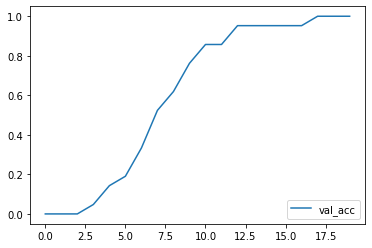

In [12]:
model = train_mobileV2(X_train, Y_train, X_test, Y_test, 20)

##Faster-Grad-CAM

In [13]:
model_grad, kmeans, channel_weight, channel_adress, vector_normal = train_faster_gradcam(pa_train, gu_train, model)

Making Database...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40


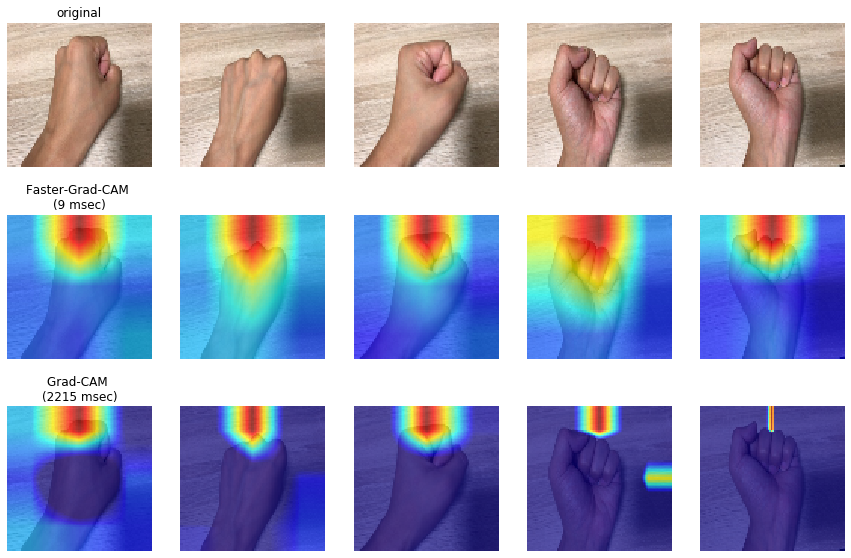

In [14]:
show_result(model, model_grad, "block_16_expand_relu", gu_test, [0,2,4,6,8], kmeans, channel_weight, channel_adress)

#Save output files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from sklearn.externals import joblib

path = "model/"
model_json = model_grad.to_json()
open(path + 'model.json', 'w').write(model_json)
model_grad.save_weights(path + 'weights.h5')

joblib.dump(kmeans, path + 'k-means.pkl.cmp', compress=True)

np.savetxt(path + "channel_weight.csv", channel_weight, delimiter=",")
np.savetxt(path + "channel_adress.csv", channel_adress, delimiter=",")
np.savetxt(path + "vector_pa.csv", vector_normal, delimiter=",")

 Finally transfer output files to your RaspberryPi or PC.